<a href="https://colab.research.google.com/github/LewNeko/Data-Mining-Group-Project/blob/main/AJ_4_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍽️ Recipe Reviews – Fully‑Commented NLP → ML Pipeline  

This notebook is **heavily annotated** so you can see *exactly* what happens at each stage:

* **Linguistic preprocessing** with **spaCy** (HTML un‑escape → lower‑case → lemmatise → remove stop‑words/non‑alphabetic tokens).  
* Build a **bag‑of‑words** representation using scikit‑learn’s `TfidfVectorizer` (1‑ and 2‑grams).  
* **Class‑imbalance handling** using *sampling with replacement* (a.k.a. bootstrapping) to up‑sample minority classes – yes, that means duplicating existing rows.  
* Train & evaluate 4 baseline models (Multinomial NB, k‑NN, Linear SVM, and a **tiny ANN** with a single 50‑unit hidden layer to keep runtime low).  
* Plots for raw vs. balanced class distributions and a bar‑chart of model accuracies.

Feel free to tweak any parameter and re‑run!

In [ ]:
# --------------------------------------------------------------------------------
# 1️⃣  Ensure spaCy + English model are installed.
#    This cell runs only once; subsequent executions are instant.
# --------------------------------------------------------------------------------
import importlib, subprocess, sys
def ensure_spacy_model():
    # Install spaCy if missing
    if importlib.util.find_spec("spacy") is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy==3.7.2"])
    import spacy
    try:
        spacy.load("en_core_web_sm")
    except OSError:
        # Model not present – download it.
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    print("✅ spaCy + model ready!")
ensure_spacy_model()

✅ spaCy + model ready!


In [ ]:
# --------------------------------------------------------------------------------
# 2️⃣  Imports & configuration parameters
# --------------------------------------------------------------------------------
import pandas as pd, numpy as np, re, html, spacy, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy import sparse

# ⚙️ Adjust these as needed
RAW_PATH            = "Recipe Reviews and User Feedback Dataset.csv"
N_ROWS              = None          # load full data; set to int for quicker experiments
TEST_SIZE           = 0.20
RANDOM_STATE        = 42
MAX_TFIDF_FEATURES  = 12000         # vocab size
BALANCE_DATA        = True          # up‑sample minority classes


In [ ]:
# --------------------------------------------------------------------------------
# 3️⃣  Load the raw CSV + minimal filtering
# --------------------------------------------------------------------------------
df = pd.read_csv(RAW_PATH, nrows=N_ROWS)

# Keep rows that have a valid star rating (1‒5) and non‑empty review text
df = df[df['stars'].between(1, 5)].dropna(subset=['text']).reset_index(drop=True)
print("📊 DataFrame shape after filtering:", df.shape)
df.head()

📊 DataFrame shape after filtering: (16484, 15)


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,5,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2Do918IutExN0pWEOFMU4cbiT8v,u_BALTQJIvWtYr,nikhita,1,1661354351,0,3,1,5,518,amazing! my boyfriend loved it so much! going ...
4,6,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_24hhcbywpsgGqG7yeDFH1IPZCb8,u_HuJVXMzQqJoI,Sandy1256,1,1644088805,0,11,0,5,833,Wow!!! This recipe is excellent as written!! ...


In [ ]:
# --------------------------------------------------------------------------------
# 4️⃣  spaCy linguistic preprocessing (lemmatisation)
# --------------------------------------------------------------------------------
#  • We disable parser / NER / tagger for speed – we only need tokenisation + lemmatisation.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])
nlp.max_length = 2_000_000  # safety for very long reviews

def spacy_lemmatise(text: str) -> str:
    """Preprocess a single review:
    1. Un‑escape HTML entities (e.g. '&#34;' → '"').
    2. Lower‑case the text (spaCy is case‑aware, but this keeps vocab smaller).
    3. Let spaCy tokenize, then:
       • keep alphabetic tokens only (drop numbers/punctuation)
       • drop built‑in stop‑words (e.g. 'the', 'and')
       • replace each token by its canonical lemma (e.g. 'running' → 'run')
    4. Return a **space‑joined string of lemmas** – perfect for bag‑of‑words.
    """
    text = html.unescape(text)          # un‑escape HTML sequences
    doc = nlp(text.lower())             # tokenize + POS/lemma
    lemmas = [tok.lemma_ for tok in doc
              if tok.is_alpha and not tok.is_stop]
    return " ".join(lemmas)

# 🚀 Apply to every review (prints progress every 10k for large datasets)
lemmatised_reviews = []
for i, review in enumerate(df['text'].astype(str)):
    lemmatised_reviews.append(spacy_lemmatise(review))
    if (i + 1) % 10000 == 0:
        print(f"{i+1:,} reviews lemmatised")

df['lemmas'] = lemmatised_reviews
df[['stars', 'lemmas']].head()

c:\Users\allen\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


10,000 reviews lemmatised


,stars,lemmas
0,5,tweaked little removed onions onion haters hou...
1,5,bush white chili bean recipe super simple writ...
2,5,complicated white chicken chili recipe years r...
3,5,amazing boyfriend loved going week
4,5,wow recipe excellent written change oz jar gre...


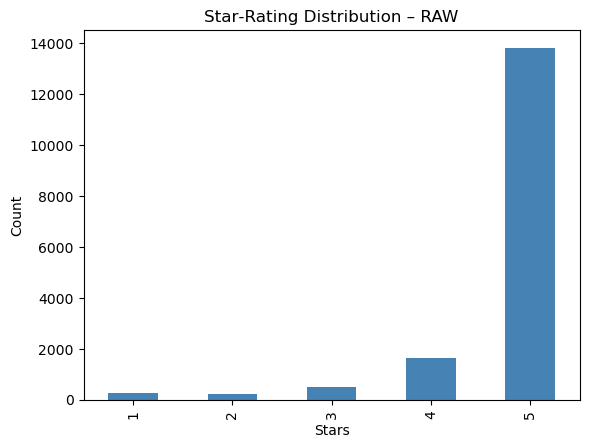

In [ ]:
# --------------------------------------------------------------------------------
# 5️⃣  Visualise class imbalance (raw distribution)
# --------------------------------------------------------------------------------
df['stars'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Star‑Rating Distribution – RAW'); plt.xlabel('Stars'); plt.ylabel('Count')
plt.show()

✅ Balanced rows: 69135


C:\Users\allen\AppData\Local\Temp\ipykernel_5772\3873777537.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(majority_size,


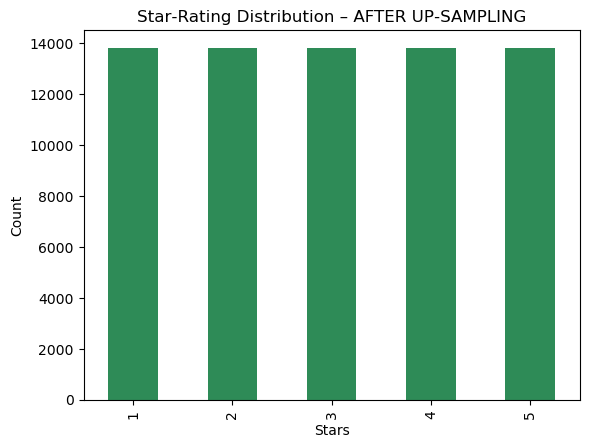

In [ ]:
# --------------------------------------------------------------------------------
# 6️⃣  (Optional) Balance the dataset with up‑sampling
# --------------------------------------------------------------------------------
if BALANCE_DATA:
    # Up‑sampling = randomly re‑draw *with replacement* from each minority class
    # until every class has the same number of rows as the majority class.
    # So yes: some reviews are duplicated verbatim.
    majority_size = df['stars'].value_counts().max()
    df_bal = (
        df.groupby('stars', group_keys=False)
          .apply(lambda x: x.sample(majority_size,
                                    replace=True,  # <-- sampling *with replacement*
                                    random_state=RANDOM_STATE))
          .reset_index(drop=True)
    )
    print("✅ Balanced rows:", len(df_bal))
    df_bal['stars'].value_counts().sort_index().plot(kind='bar', color='seagreen')
    plt.title('Star‑Rating Distribution – AFTER UP‑SAMPLING'); plt.xlabel('Stars'); plt.ylabel('Count')
    plt.show()
else:
    df_bal = df.copy()


In [ ]:
# --------------------------------------------------------------------------------
# 7️⃣  Bag‑of‑Words feature matrix with TF‑IDF weighting
# --------------------------------------------------------------------------------
# Notes:
# • tokenizer=str.split   -> reuse our space‑separated lemmas (no extra regex work)
# • lowercase=False       -> already lower‑cased earlier
# • ngram_range=(1,2)     -> include unigrams + bigrams
vectorizer = TfidfVectorizer(
    max_features=MAX_TFIDF_FEATURES,
    ngram_range=(1, 2),
    tokenizer=str.split,
    lowercase=False
)

X_text = vectorizer.fit_transform(df_bal['lemmas'])

# Add a lightweight numeric feature block: thumbs_up / thumbs_down (normalised 0‑1)
thumbs = df_bal[['thumbs_up', 'thumbs_down']].fillna(0)
thumbs_norm = thumbs / thumbs.max()

# Combine sparse TF‑IDF with dense numeric matrix
X = sparse.hstack([X_text, sparse.csr_matrix(thumbs_norm.values)])
y = df_bal['stars']
print("🔢 Feature matrix:", X.shape)

c:\Users\allen\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


🔢 Feature matrix: (69135, 12002)


In [ ]:
# --------------------------------------------------------------------------------
# 8️⃣  Stratified train/test split
# --------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (55308, 12002) Test: (13827, 12002)


In [ ]:
# --------------------------------------------------------------------------------
# 9️⃣  Train & evaluate baseline models
# --------------------------------------------------------------------------------
models = {
    # Multinomial NB is a natural baseline for word‑count features
    'Multinomial NB': MultinomialNB(),
    # Cosine k‑NN can capture local similarity in TF‑IDF space
    'k‑NN (cosine, k=5)': KNeighborsClassifier(n_neighbors=5, metric='cosine'),
    # Linear SVM is often a top performer for sparse text data
    'Linear SVM': LinearSVC(),
    # Tiny ANN: single hidden layer (50) → fast to train
    'ANN (1×50 relu)': Pipeline([
        ('scale', StandardScaler(with_mean=False)),  # scale sparse inputs
        ('mlp', MLPClassifier(hidden_layer_sizes=(2,),  # <= smaller layer
                              activation='relu',
                              max_iter=150,
                              random_state=RANDOM_STATE))
    ])
}

results = []
for name, model in models.items():
    print(f"\n⚙️  Training {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results.append({'Model': name, 'Accuracy': round(acc, 4)})
    print(classification_report(y_test, preds, zero_division=0))
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
results_df


⚙️  Training Multinomial NB
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2766
           2       0.99      0.98      0.99      2765
           3       0.93      0.91      0.92      2765
           4       0.76      0.82      0.79      2766
           5       0.82      0.77      0.80      2765

    accuracy                           0.90     13827
   macro avg       0.90      0.90      0.90     13827
weighted avg       0.90      0.90      0.90     13827


⚙️  Training k‑NN (cosine, k=5)
              precision    recall  f1-score   support

           1       0.99      1.00      1.00      2766
           2       0.98      1.00      0.99      2765
           3       0.95      1.00      0.97      2765
           4       0.83      0.96      0.89      2766
           5       0.97      0.75      0.85      2765

    accuracy                           0.94     13827
   macro avg       0.95      0.94      0.94     13827
weighted avg   

,Model,Accuracy
2,Linear SVM,0.9622
1,"k‑NN (cosine, k=5)",0.9416
0,Multinomial NB,0.8964
3,ANN (1×50 relu),0.7728


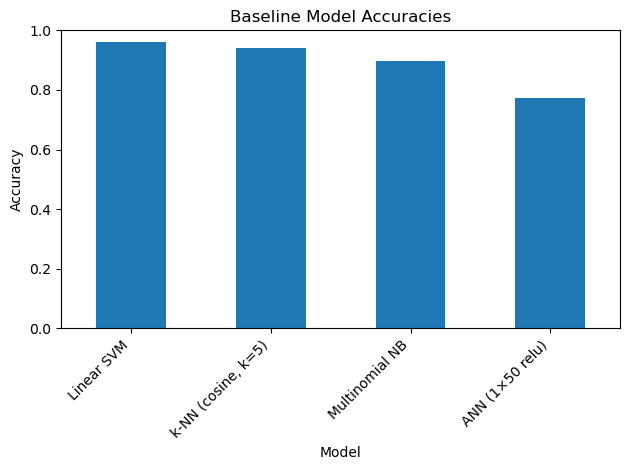

In [ ]:
# --------------------------------------------------------------------------------
# 🔟  Visual comparison of accuracies
# --------------------------------------------------------------------------------
results_df.plot(kind='bar', x='Model', y='Accuracy', legend=False)
plt.title('Baseline Model Accuracies'); plt.ylim(0, 1); plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()